In [2]:
#Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
import datetime
import numpy as np

In [3]:
#read data from zipped csv file using url
df = pd.read_csv('https://d3ony5rmo3oa45.cloudfront.net/careers/data_take_home_bookings.zip')

In [4]:
#group data by country
df_by_country = df.groupby('country')

#serie with the top N countries by number of bookings
#for more or less N number of countries change the value in head(N)
s_country = df_by_country.size().to_frame().sort_values([0], ascending = False).head(5).reset_index()['country']

#generation of a dictionary between country name and alpha_3 codification
l_country_shortname = list()
d_country_longname = {}
for country in s_country:
    l_country_shortname.append(country)
    d_country_longname.update({country: pycountry.countries.get(alpha_3=country).name})


In [5]:
#initialization of some dict and lists to analize data of this top N countries
d_popular_client_data = {}
l_long_name = list()
l_number_bookings = list()
l_average_nightly_rate = list()
l_pct_repited_guests = list()
l_pct_canceled_bookings = list()
     
#search of data for each country of the top N
for country in l_country_shortname: 
    
    #definition of some search conditions
    country_cond = df['country'] == country
    cancel_cond = (df['country'] == country)&(df['is_canceled'] == 1)
    not_cancel_cond = (df['country'] == country)&(df['is_canceled'] == 0)
    repited_cond = (df['country'] == country)&(df['is_repeated_guest'] == 1)
    
    #the name of the actual country we are inspecting 
    long_name = d_country_longname[country]    
    
    #number of total bookings by country
    number_bookings = df[country_cond].shape[0]
    
    #use the conditions to get the percentage of canceled booking and repited guests
    pct_canceled_bookings = round(((df[cancel_cond].shape[0])*100)/number_bookings,2)
    pct_repited_guests = round(((df[repited_cond].shape[0])*100)/number_bookings,2)
    
    #calculate the money that come from each country just taking in count the not canceled booking requests
    income = df[not_cancel_cond].adr.sum()
    
    #number of booking requests not canceled
    n_bookings_not_canceled = df[not_cancel_cond].shape[0]
    
    #number of nights by country
    df_number_nights = df[not_cancel_cond][['stays_in_weekend_nights','stays_in_week_nights']]
    mean_number_nights = round(df_number_nights.sum(axis = 1).mean())
    total_number_nights = df_number_nights.sum(axis = 1).sum()
    
    #total average value of a night by country
    average_nightly_rate = round(income/n_bookings_not_canceled,2)
    
    #update the different list to creat a dataframe
    l_long_name.append(long_name)
    l_number_bookings.append(number_bookings)
    l_pct_repited_guests.append(pct_repited_guests)
    l_average_nightly_rate.append(average_nightly_rate)
    l_pct_canceled_bookings.append(pct_canceled_bookings)
    d_popular_client_data.update({'country': l_long_name, 'nº bookings': l_number_bookings, 'cancelation %': l_pct_canceled_bookings, 'average nightly rate': l_average_nightly_rate, 'repited guests %': l_pct_repited_guests})     

#show the dataframe to analyze the type of clients by country
df_popular_client_data = pd.DataFrame(d_popular_client_data, index=np.arange(len(l_country_shortname))) 
print("\r\nThe most popular guest origin countries are : {}".format(l_long_name))
print("\r\nThe next table let us compare the type of clients from the "+str(len(l_country_shortname))+" most popular guests origin countries.\r\n")
df_popular_client_data.head(len(l_country_shortname))


The most popular guest origin countries are : ['Somalia', 'Tonga', 'Gambia', 'Wallis and Futuna', 'Germany']

The next table let us compare the type of clients from the 5 most popular guests origin countries.



,country,nº bookings,cancelation %,average nightly rate,repited guests %
0,Somalia,48590,56.64,90.34,6.69
1,Tonga,12129,20.22,90.47,0.88
2,Gambia,10415,18.57,105.75,0.75
3,Wallis and Futuna,8568,25.41,110.30,1.05
4,Germany,7287,16.71,101.26,0.34


In [6]:
#condition to get only the bookings with a positive value
value_cond = df['adr'] > 0
print("The mean value of a room is " + str(round(df[value_cond].adr.mean(),2)))

The mean value of a room is 103.53


In [7]:
#we can correlate the columns to know if some of then has some relations that we can use to analyze
corr = df[value_cond].corr()[['adr']].sort_values(by=['adr'], ascending=False)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Usuario\AppData\Local\Temp/ipykernel_17968/1091066157.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,adr
adr,1.00
children,0.34
adults,0.27
arrival_date_year,0.20
total_of_special_requests,0.18
arrival_date_week_number,0.08
parking_lot,0.06
stays_in_week_nights,0.05
booking_changes,0.04
stays_in_weekend_nights,0.03


In [8]:
#a list with the two paramenters more related with the value(ard)
l_corr1 = list(corr.iloc[1:3].index)

#a list with another paramenters chosen manually
l_corr2 = ['acquisition_channel', 'customer_type', 'board', 'parking_lot', 'reserved_room_type']
l_param = l_corr1 + l_corr2

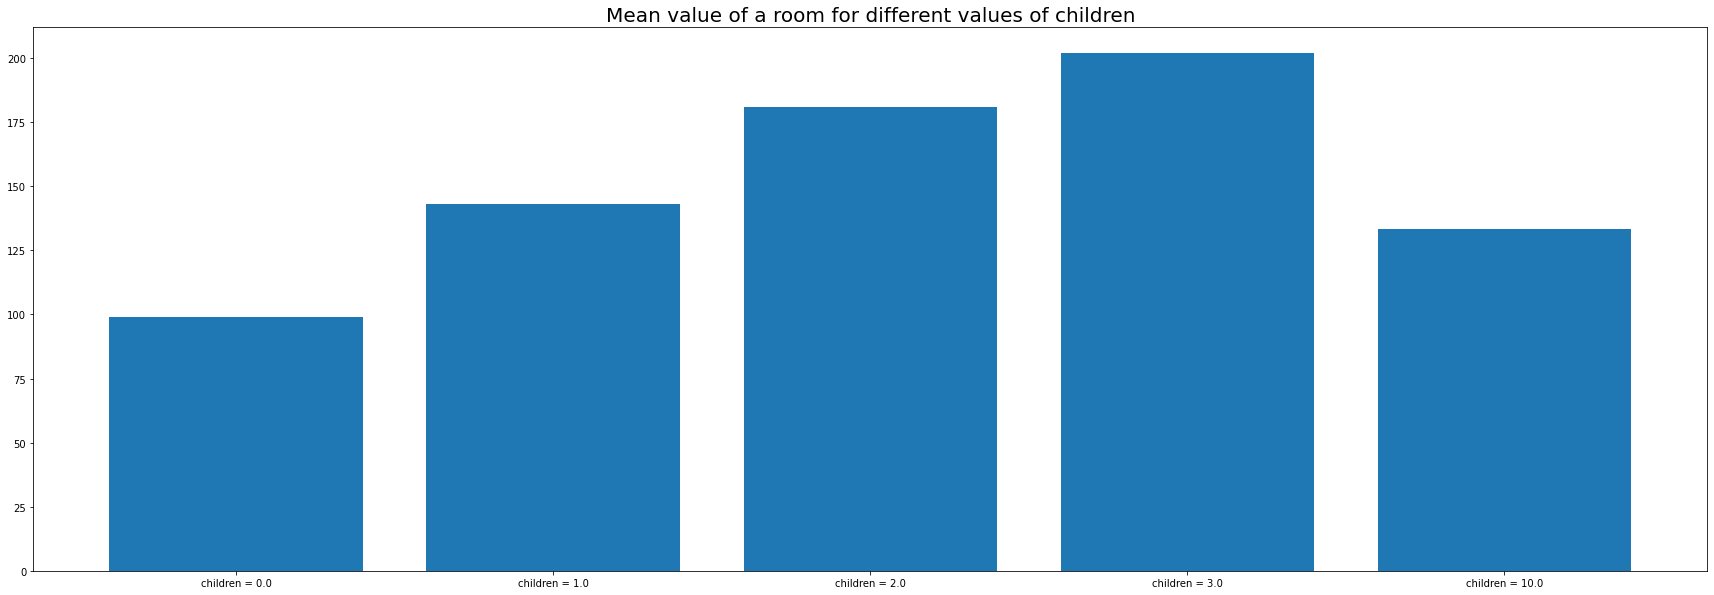

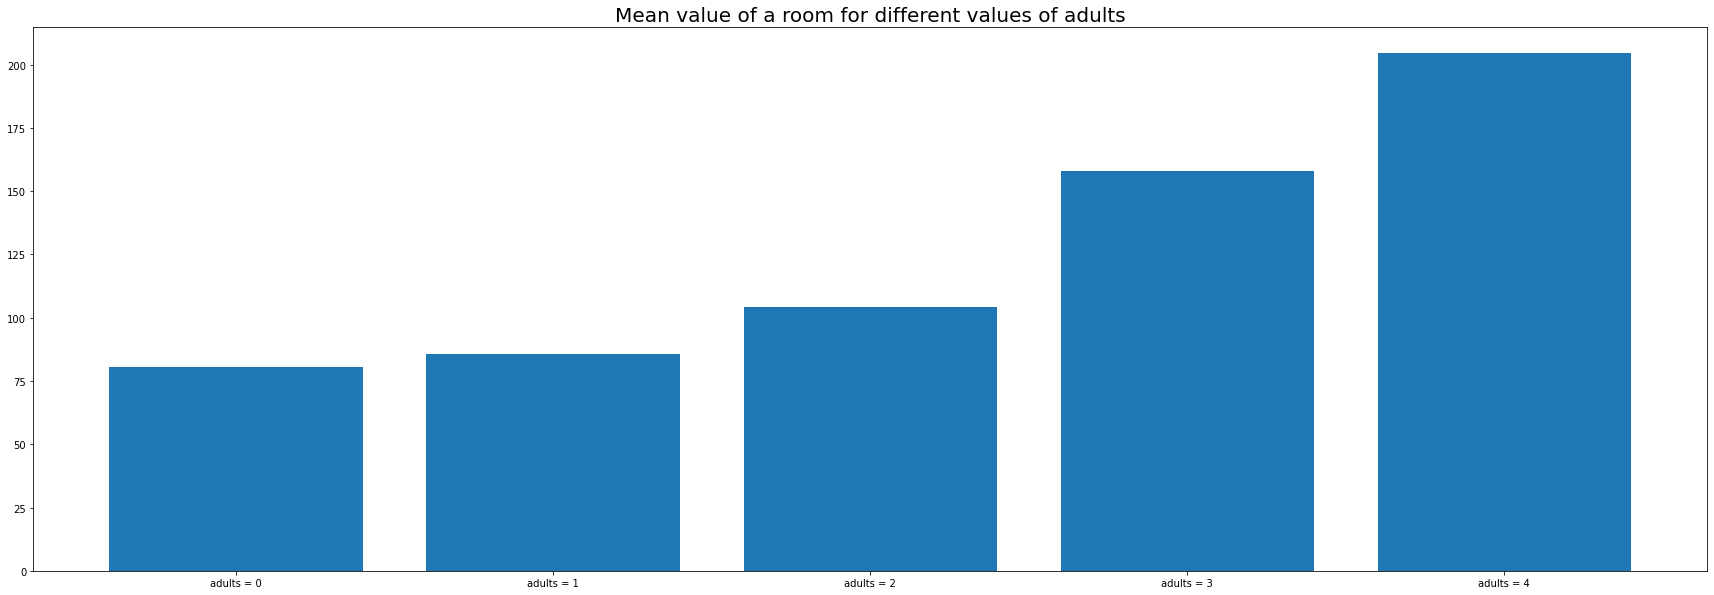

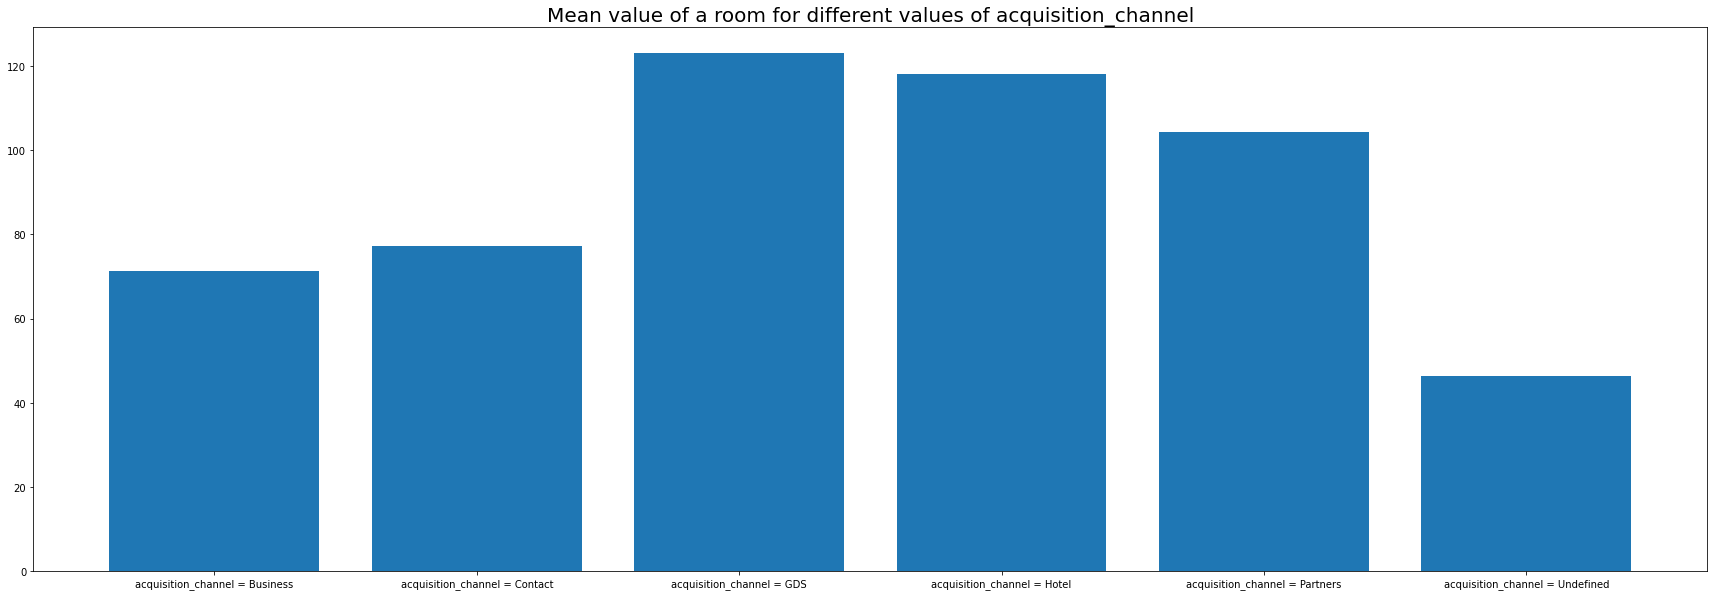

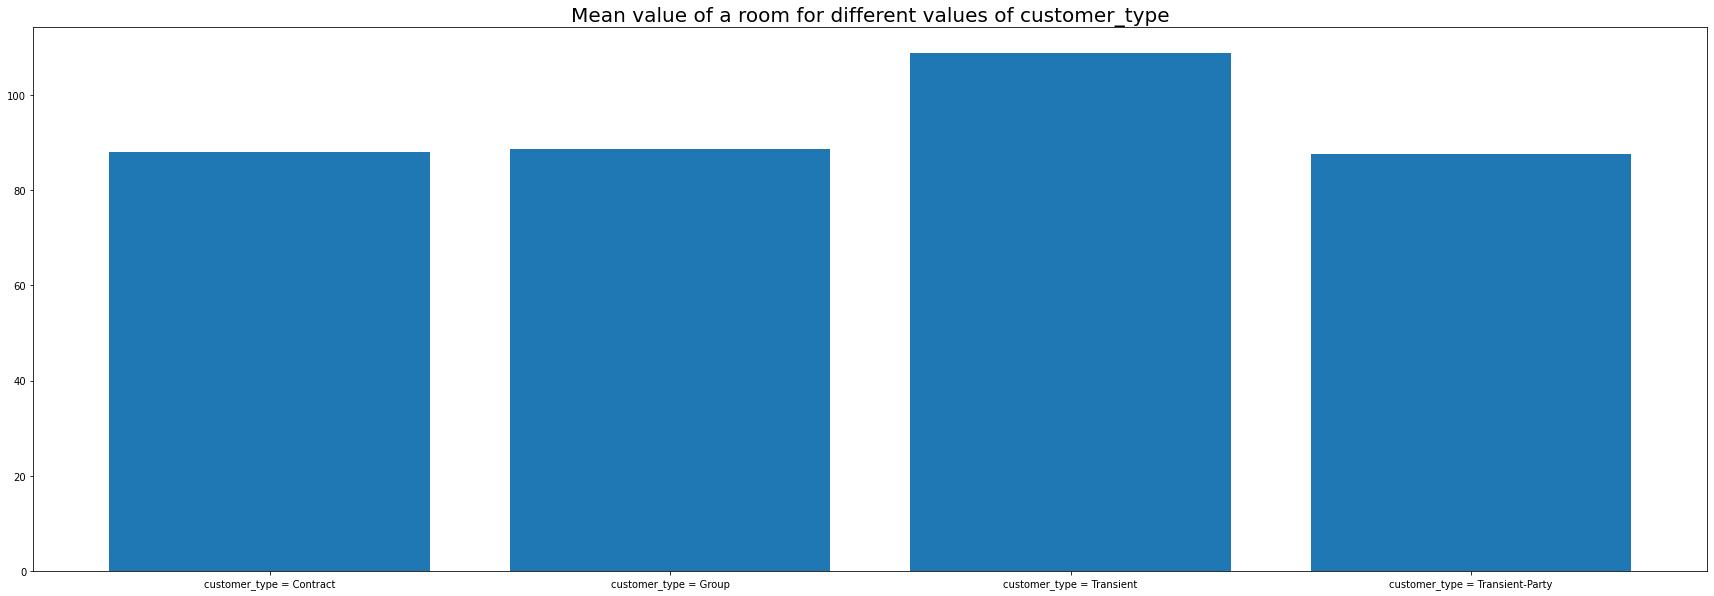

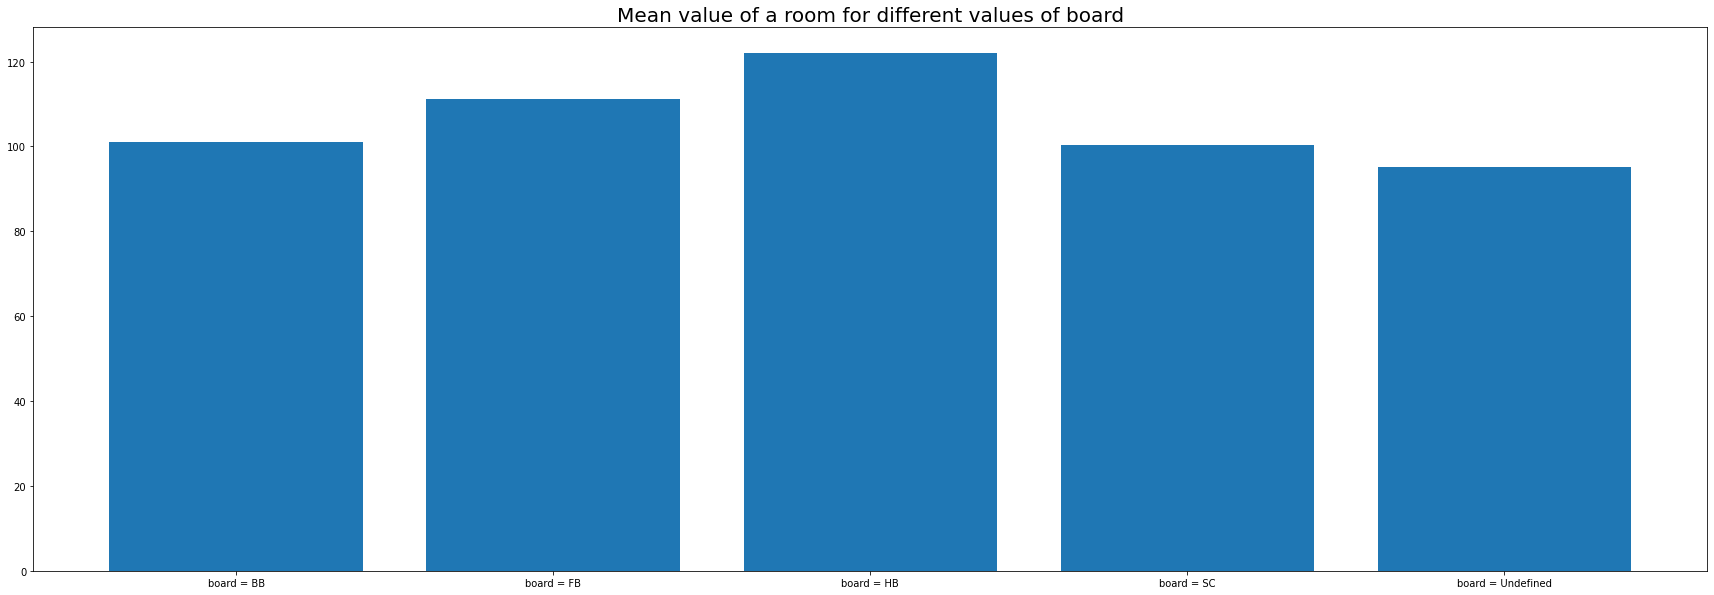

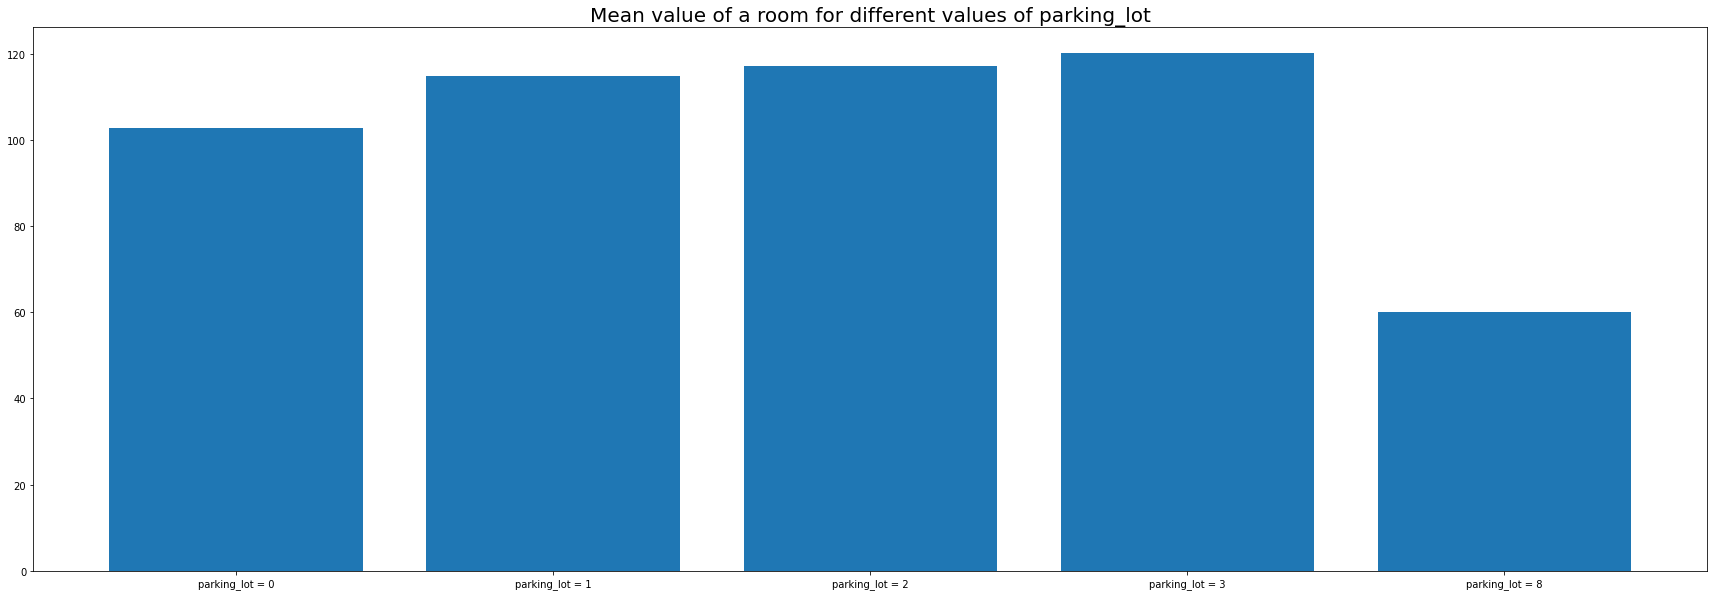

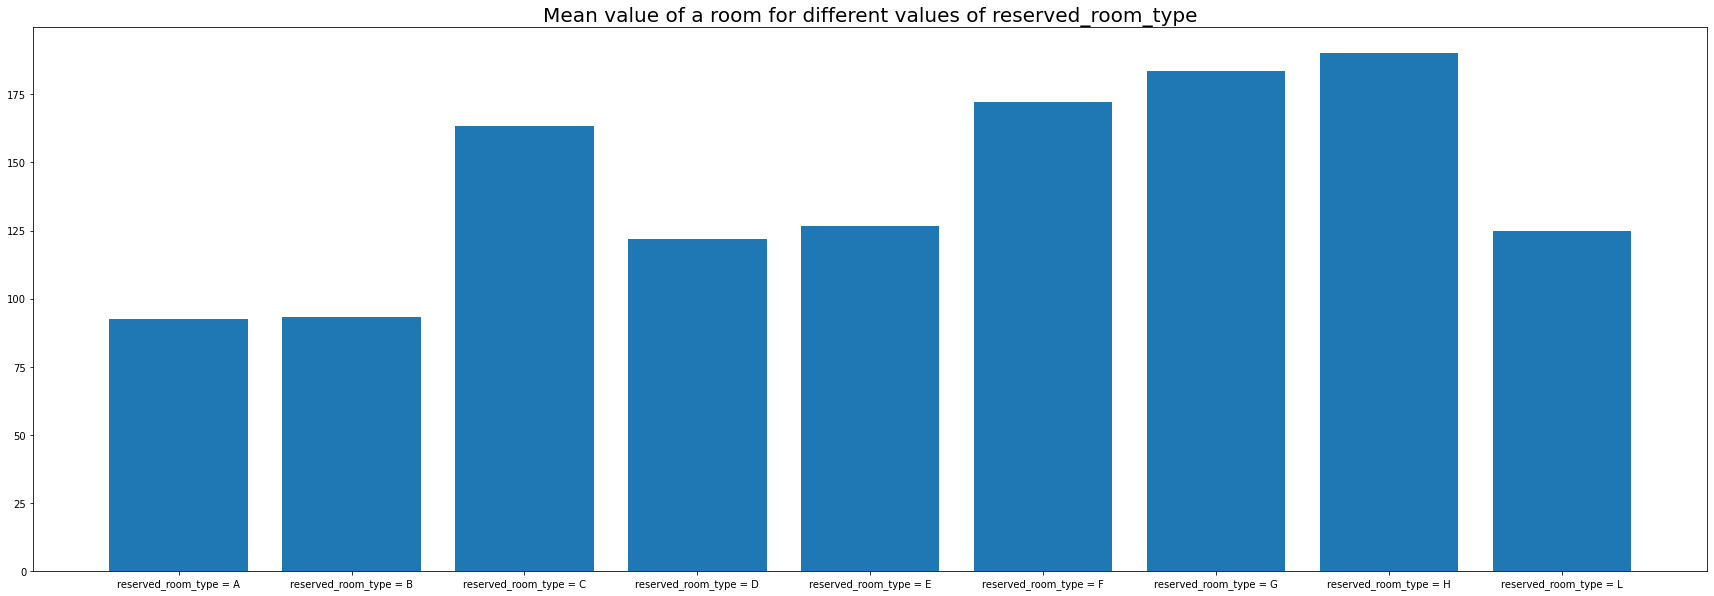

In [9]:
#we gonna inspect how change the value of a romm for the diferent options of the parameters selected before
for param in l_param:    
    d_mean_price_param = {}
    
    #get the options for the actual parameter
    l_groups = list(df[value_cond].groupby(param).groups.keys())
    for group in l_groups:
        
        #we only inspect the data with positive value and for the actual option
        group_cond = ((df['adr'] > 0) & (df[param] == group))
        value = round(df[group_cond].adr.mean(),2)
        key = param + ' = ' + str(group)
        
        #store that info in a dictionary to plot it below
        d_mean_price_param.update({key: value})
        
    #get the name of the option and the mean value of the room    
    keys = list(d_mean_price_param.keys())
    values = list(d_mean_price_param.values())
    
    #show the plots
    plt.figure(figsize=(30,10)) 
    plt.bar(range(len(d_mean_price_param)), values, tick_label=keys)
    plt.title('Mean value of a room for different values of ' + param , fontsize=20)
    plt.show()

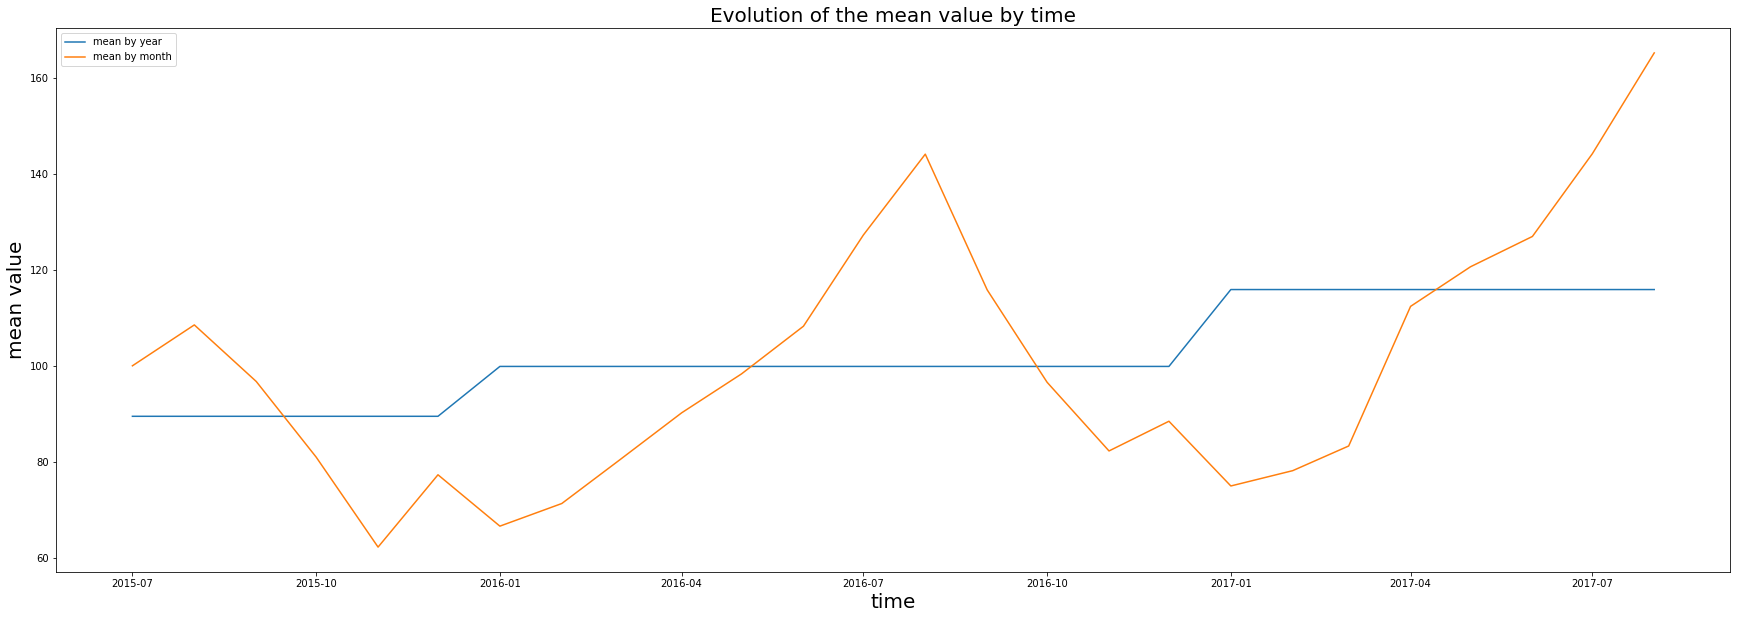

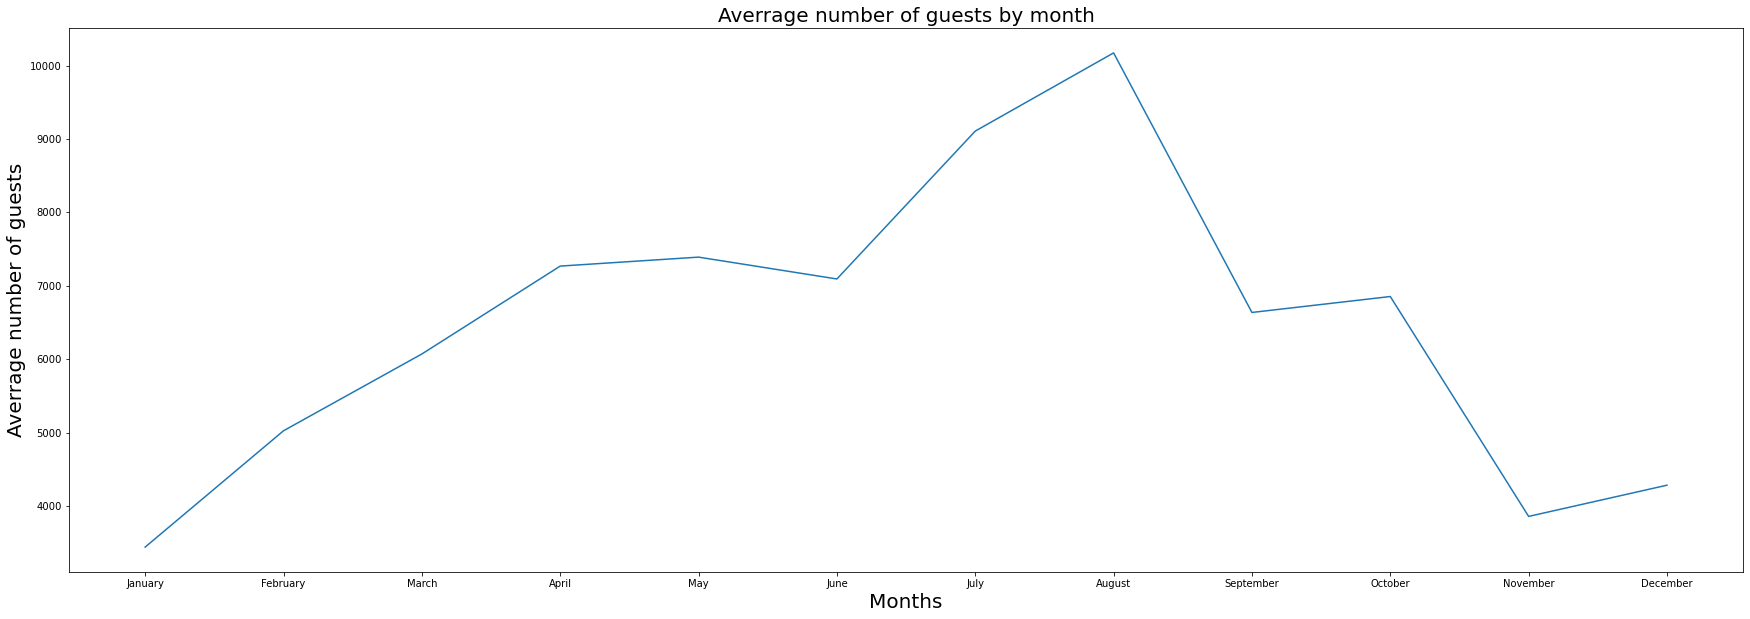

In [10]:
#lsit of the years and months that appears in the csv
l_years = list(df[value_cond].groupby('arrival_date_year').groups.keys())
l_months = list(df[value_cond].groupby('arrival_date_month').groups.keys())

#some dictionaries to organize the data
d_mean_value_year = {}
d_mean_value_month = {}
d_number_guests_month = {}

#we analyze the data for each of the years
for year in l_years:
    
    #mean value of the room for each year
    year_cond =((df['adr'] > 0) & (df['arrival_date_year'] == year)) 
    mean_year = round(df[year_cond].adr.mean(),2)
    
    #we analyze the data for each month of each year    
    for month in l_months:
        
        #condition to select one by one
        y_m_cond = ((df['adr'] > 0) & (df['arrival_date_year'] == year) & (df['arrival_date_month'] == month))
        
        #mean value of the room for each month of each year
        mean_y_m = round(df[y_m_cond].adr.mean(),2)     
        
        #we need to store the month and the year in the same type
        month = datetime.datetime.strptime(month, "%B").month
        year = pd.to_datetime(year, format='%Y').year
        
        #we only store the value of the months that has a confirmed booking
        if( mean_y_m > 0):  
            d_mean_value_year.update({datetime.datetime(year, month, 1): mean_year}) 
            d_mean_value_month.update({datetime.datetime(year, month, 1): mean_y_m})
            
#noe we analyze the months for all the years at the same time
for month in l_months:
    month_cond = ((df['adr'] > 0) & (df['arrival_date_month'] == month))
    
    #calculate the total number of clients by month
    guests = df[month_cond].adults.sum() + df[month_cond].children.sum() + df[month_cond].babies.sum()
    
    #and now we calculate a medium value for each month
    guests /= len(l_years)
    guests = round(guests,2)  
    month = datetime.datetime.strptime(month, "%B").month
    
    #we only store the value if is positive
    if( guests > 0):            
        d_number_guests_month.update({month: guests})
            
#we need to sort the data by date
d_sorted_year = sorted(d_mean_value_year.items())
d_sorted_month = sorted(d_mean_value_month.items())
d_sorted_guests = sorted(d_number_guests_month.items())

#now we can plot the data to analyze the evolution of the price with the time
a, b = zip(*d_sorted_year)
x, y = zip(*d_sorted_month)
plt.figure(figsize=(30,10)) 
plt.plot(a, b, label = "mean by year")
plt.plot(x, y, label = "mean by month")
plt.title("Evolution of the mean value by time" , fontsize=20)
plt.ylabel("mean value" , fontsize=20)
plt.xlabel("time" , fontsize=20)
plt.legend()
plt.show()

#now we can plot the data to analyze in which month we hace more clients
z, w = zip(*d_sorted_guests)

#this list is to change again the format of the months.
lista = list()

for a in z:
    lista.append(datetime.date(1900, a, 1).strftime('%B'))
    
plt.figure(figsize=(30,10)) 
plt.plot(lista, w)
plt.title("Averrage number of guests by month" , fontsize=20)
plt.ylabel("Averrage number of guests" , fontsize=20)
plt.xlabel("Months" , fontsize=20)
plt.show()

In [11]:
not_cancel_cond = df['is_canceled'] == 0
print("\r\nOur clients have to wait a medium of " + str(round(df.days_in_waiting_list.mean())) + " days till the booking request is confirmed")
print("\r\nThe time between the booking date and the arrival date is an averrage of " + str(round(df[not_cancel_cond].booking_to_arrival_time.mean())) + " days.")



Our clients have to wait a medium of 2 days till the booking request is confirmed

The time between the booking date and the arrival date is an averrage of 80 days.


In [12]:
#calculate the number of clients in total and then the mean
df_persons = df[not_cancel_cond][['adults','children','babies']]
mean_number_clients = df_persons.sum(axis = 1).mean()

#calculate the number of nights in total and then the mean
df_nights = df[not_cancel_cond][['stays_in_weekend_nights','stays_in_week_nights']]
mean_number_nighst = df_nights.sum(axis = 1).mean()

In [13]:
 print("\r\nThe most comon booking request is from " + str(round(mean_number_clients)) + " persos for " + str(round(mean_number_nighst)) + " nights.")


The most comon booking request is from 2 persos for 3 nights.
